# ソフトマックス回帰　(softmax regression)の実装
# 目次
1. 概要
- 目標
- 下準備
- softmax関数の実装
- 多クラス交差エントロピー誤差の実装
- ソフトマックス回帰クラスの実装
- 学習

# 1. 概要
- ロジスティック回帰の一般化で，多クラスに対応した手法
- K個のクラス識別問題を考える．$\boldsymbol{x}$：入力データ，$\boldsymbol{t}$：教師データ

\begin{align}
\it{D}=\left\{\left(\boldsymbol{x}_i,\boldsymbol{t}_i\right)\right\}_{i=1}^{N}\, ,\boldsymbol{x}\in\mathbb{R}^d,\, \boldsymbol{t}\in\left\{1,\cdots,K\right\}
\end{align}

- 各クラスの事後確率を求める．各クラスごとに重み行列 $\boldsymbol{w}^{(𝑗)}$を持つ．
$$
P(y=1|\,\boldsymbol{x})=\frac{\exp({\boldsymbol{w}^{(1)\top}\boldsymbol{x}})}{\sum_{j=1}^{K}\exp{(\boldsymbol{w}^{(j)\top}\boldsymbol{x}})}\\
P(y=2|\,\boldsymbol{x})=\frac{\exp({\boldsymbol{w}^{(2)\top}\boldsymbol{x}})}{\sum_{j=1}^{K}\exp{(\boldsymbol{w}^{(j)\top}\boldsymbol{x}})}\\
\vdots\\
P(y=K|\,\boldsymbol{x})=\frac{\exp({\boldsymbol{w}^{(K)\top}\boldsymbol{x}})}{\sum_{j=1}^{K}\exp{(\boldsymbol{w}^{(j)\top}\boldsymbol{x}})}
$$

# 2. 目標
- ソフトマックス回帰を実装して，mnist（手書き数字データセット）を識別する．
- まず**活性化関数**の一種である**softmax**関数と，**交差エントロピー関数**を実装する．その後**確率的勾配降下法**を実装し，**SoftmaxRegression**クラスを実装する．

# 3. 下準備
## 3.1 ライブラリのインポート
- matplotlib: 図やグラフの描画など．
- numpy: 行列演算など
- sklearn: scikit-learn．様々な機械学習のモデルが利用できるが，今回はMNISTのデータをダウンロードするのに用いる．

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from __future__ import print_function

In [2]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220517

from test_softmax import *

/content/drive/My Drive/Colab Notebooks/先端人工知能論I/20220517


## 3.2 MNISTデータの読み込み


- データをダウンロードする．一度ダウンロードすると，その後はデータを参照して読み込んでくれるので，毎回ダウンロードしなくても良くなる．
- X：画像データ(各画像784次元）， Y：ラベル
- mnistのデータは，0~255のint型で表されているが，これを**255で割って正規化**する．

In [5]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)
X = np.array(X / 255.0, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)

### データセットの可視化

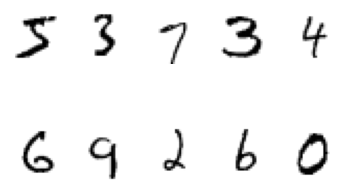

In [6]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i * 6500].reshape(28, 28), cmap='gray_r')
    plt.axis("off")

### 学習用・テスト用データの分割
- 訓練データで学習し，同じ訓練データで性能の評価を行うと，訓練データでは良い性能を示すが，データを少しでも変えると性能が低下してしまうことがある（**過学習**）．
- よって，学習する訓練データとは異なるテストデータで性能評価を行う．

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

# 4. softmax関数の実装
活性化関数の一種であるsoftmax関数を実装する．
- 関数：softmax
  - 入力：$\boldsymbol{X}=(\boldsymbol{x}_1,\boldsymbol{x}_2,\cdots,\boldsymbol{x}_N)^\top\in\mathbb{R}^{N\times K}$
  - 出力：$\boldsymbol{Y}=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots,\boldsymbol{y}_N)^\top\in\mathbb{R}^{N\times K},\,\,\,y_{nk} = softmax(\boldsymbol{x}_n)_k$
  - オーバーフローを防ぐために$\boldsymbol{x}_n$の最大値を$\boldsymbol{x}_n$自身から引く
$$
\begin{align}
softmax(\boldsymbol{x})_k&= \frac{\exp (x_{k})} {\Sigma_{i=1}^{K}{\exp (x_{i})}}\\
&=\frac{\exp (-x_{max})\exp (x_{k})}{\exp (-x_{max})\Sigma_{i=1}^{K}{\exp (x_{i})}}=\frac{\exp (x_{k}-x_{max})} {\Sigma_{i=1}^{K}{\exp (x_{i}-x_{max})}}
\end{align}
$$

<details>
<summary>
ヒント
</summary>
<ol>
    <li>最大値
    <ul>
    <ul> 
    <li> 

```np.max()```

 </li>
        <li>


```axis=1```を指定するとデータ
  $\boldsymbol{x_n}$ごとに最大値を計算できる</li>
        <li>行列のshapeを変えたくない場合は，```keepdims=True```を指定する</li>
    </ul></li>
    <li>$\exp$
    <ul>
    <li>```np.exp()```</li>
    </ul></li>
    <li>合計
    <ul>
    <li>```np.sum()```</li>
    <li>```axis=1```を指定するとデータ$\boldsymbol{x_n}$ごとに合計を計算できる</li>
    <li>行列のshapeを変えたくない場合は，```keepdims=True```を指定する</li>
    </ul></li>
</ol>
</details>

In [9]:
def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  y = exp_x / np.sum(exp_x, axis=1, keepdims=True)
  return y

テスト．以下のセルを実行

In [10]:
test_softmax(softmax)

ok!


# 5. 多クラスの交差エントロピー誤差の実装
- 関数：cross_entropy
    - 入力： $Y=(\boldsymbol{y}_1,\boldsymbol{y}_2,\cdots,\boldsymbol{y}_N)^\top\in \mathbb{R}^{N\times K}$, $T=(\boldsymbol{t}_1,\boldsymbol{t}_2,\cdots,\boldsymbol{t}_N)^\top\in \mathbb{R}^{N\times K}$<br />
$\boldsymbol{y}_n$はソフトマックス関数の出力，$\boldsymbol{t}_n$は教師ラベル(1-of-K表現)

    - 出力： 
    $$L=-\frac{1}{N}\sum_{n=1}^N \sum_i \boldsymbol t_{n,i} \log \boldsymbol y_{n,i}\in\mathbb{R}^1
$$


<details>
<summary>
ヒント
</summary>
<ol>
    <li>

$\log$
    <ul> 
        <li>```np.log()```</li>
    </ul></li>
    <li>合計
    <ul>
    <li>```np.sum()```</li>
    </ul></li>
    <li>平均
    <ul>
    <li>```np.mean()```</li>
    </ul></li>
</ol>
</details>

In [11]:
def cross_entropy(y, t):
  L = -np.mean(np.sum(t * np.log(y), axis=1))
  return L

テスト．以下のセルを実行

In [12]:
test_cross_entropy(cross_entropy)

ok!


# 6. ソフトマックス回帰の実装
ソフトマックス回帰クラスを実装する．
## 6.1 勾配降下法の実装
SoftmaxRegressionクラスのgradient_decent関数を実装してください．
- 関数：gradient_descent  
    - 入力：
        - 学習データ： $\boldsymbol{X}\in\mathbb{R}^{N\times D}$
        - 予測ラベル：$\boldsymbol{Y}\in\mathbb{R}^{N\times K}$
        - 教師ラベル：$\boldsymbol{T}\in\mathbb{R}^{N\times K}$
        - 学習率：$\epsilon \in \mathbb{R}$
    - 更新：
        - 重みとバイアス $\boldsymbol{W}\,\boldsymbol{b}$
        
- 勾配降下法: （$\boldsymbol{W},\boldsymbol{b}$：パラメータ，$\epsilon$：学習率）
$$
\boldsymbol{W}\leftarrow\boldsymbol{W}-\epsilon\nabla_{\boldsymbol{W}}L\\
\boldsymbol{b}\leftarrow\boldsymbol{b}-\epsilon\nabla_{\boldsymbol{b}}L
$$
- ソフトマックス回帰の勾配 :
\begin{align}
\nabla_{\boldsymbol{W}}L&=\frac{1}{N}\boldsymbol{X}^\top(\boldsymbol{Y}-\boldsymbol{T})\\
\nabla_{\boldsymbol{b}}L&=\frac{1}{N}(1,1,...,1)(\boldsymbol{Y}-\boldsymbol{T})
\end{align}

<details>
<summary>
ヒント
</summary>
<ol>
    <li>
    
行列の積
    <ul> 
        <li>```np.dot()```</li>
    </ul></li>
    <li>合計
    <ul>
    <li>```np.sum()```</li>
    </ul></li>
</ol>
</details>

In [13]:
class SoftmaxRegression:
    def __init__(self, n_in, n_out):
        self.W = np.random.uniform(0.08, -0.08, (n_in, n_out)) #勾配の初期化
        self.b = np.zeros(n_out) #バイアスの初期化
        
    def gradient_decent(self, X, Y, T, eps):
        batchsize = X.shape[0]
        delta = Y - T
        self.W -= eps * np.dot(X.T, delta) / batchsize
        self.b -= eps * np.sum(delta, axis=0) / batchsize
        
    def train(self, x, t, lr):
        y = softmax(np.dot(x, self.W) + self.b) #予測
        self.gradient_decent(x, y, t, lr) #パラメータの更新
        loss = cross_entropy(y, t) #ロスの算出
        return y, loss

    def test(self, x, t):
        y = softmax(np.dot(x, self.W) + self.b) #予測
        loss = cross_entropy(y, t) #ロスの算出
        return y, loss

テスト．以下のセルを実行

In [14]:
test_gradient_decent(SoftmaxRegression)

ok!


# 7. 学習
## 7.1 モデルの初期化
入力は784次元，出力は10次元

In [15]:
model = SoftmaxRegression(784, 10)

## 7.2 ハイパーパラメータの設定
- 学習epoch数は20
    - epoch数とは，学習データを何回学習するかを表す数である．
- バッチサイズは100
    - ミニバッチとは少数のサンプルからなる集合である．
- 学習率は1

In [16]:
n_epoch = 20
batchsize = 100
lr = 1

## 7.3 学習
交差エントロピー誤差を確率的勾配降下法を用いて最小化する．

In [18]:
for epoch in range(n_epoch):
    print ('epoch %d |　' % epoch, end="")
    
    # Training
    sum_loss = 0
    pred_label = []
    perm = np.random.permutation(train_n) #ランダムに並び替える
    
    for i in range(0, train_n, batchsize): #ミニバッチごとに学習を行う
        x = train_x[perm[i:i+batchsize]]
        y = train_y[perm[i:i+batchsize]]
        
        pred, loss = model.train(x, y, lr)
        sum_loss += loss * x.shape[0]
        # pred には， (N, 10)の形で，画像が0~9の各数字のどれに分類されるかの事後確率が入っている
        # そこで，最も大きい値をもつインデックスを取得することで，識別結果を得ることができる
        pred_label.extend(pred.argmax(axis=1))

    loss = sum_loss / train_n
    # 正解率
    accu = accuracy_score(pred_label, np.argmax(train_y[perm], axis=1))
    print('Train loss %.3f, accuracy %.4f |　' %(loss, accu), end="")
    
    
    # Testing
    sum_loss = 0
    pred_label = []
    
    for i in range(0, test_n, batchsize):
        x = test_x[i: i+batchsize]
        y = test_y[i: i+batchsize]
        
        pred, loss = model.test(x, y)
        sum_loss += loss * x.shape[0]
        pred_label.extend(pred.argmax(axis=1))
        
    loss = sum_loss / test_n
    
    accu = accuracy_score(pred_label, np.argmax(test_y, axis=1))
    print('Test loss %.3f, accuracy %.4f' %(loss, accu) )

epoch 0 |　Train loss 0.265, accuracy 0.9256 |　Test loss 0.330, accuracy 0.9056
epoch 1 |　Train loss 0.266, accuracy 0.9244 |　Test loss 0.296, accuracy 0.9191
epoch 2 |　Train loss 0.264, accuracy 0.9253 |　Test loss 0.291, accuracy 0.9194
epoch 3 |　Train loss 0.265, accuracy 0.9251 |　Test loss 0.298, accuracy 0.9157
epoch 4 |　Train loss 0.263, accuracy 0.9260 |　Test loss 0.310, accuracy 0.9137
epoch 5 |　Train loss 0.262, accuracy 0.9277 |　Test loss 0.317, accuracy 0.9118
epoch 6 |　Train loss 0.260, accuracy 0.9273 |　Test loss 0.300, accuracy 0.9176
epoch 7 |　Train loss 0.260, accuracy 0.9280 |　Test loss 0.303, accuracy 0.9174
epoch 8 |　Train loss 0.263, accuracy 0.9251 |　Test loss 0.305, accuracy 0.9182
epoch 9 |　Train loss 0.260, accuracy 0.9271 |　Test loss 0.314, accuracy 0.9111
epoch 10 |　Train loss 0.260, accuracy 0.9278 |　Test loss 0.294, accuracy 0.9201
epoch 11 |　Train loss 0.261, accuracy 0.9263 |　Test loss 0.299, accuracy 0.9171
epoch 12 |　Train loss 0.260, accuracy 0.9257 |　Tes

テストの正解率が92%程度になると成功です．